In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from agots.multivariate_generators.multivariate_data_generator import MultivariateDataGenerator

In [4]:
def simple_sin_generator(cycle_duration=10,
                   phase_shift=2*np.pi,
                   amplitude=10):
    phase_angle = 2*np.pi / cycle_duration
    while True:
        value = amplitude * np.sin(phase_shift)
        yield value
        phase_shift = np.around((phase_shift + phase_angle) % (2*np.pi), decimals=15)

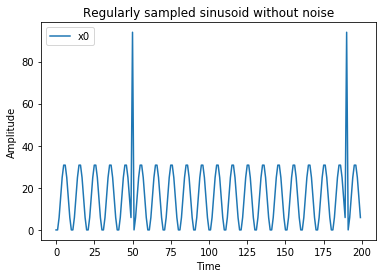

In [7]:
np.random.seed(1337)

STREAM_LENGTH = 200 #Number Of Sample Points
N = 1 #Number of Timeseries to be generated
K = 0 #Number of Timeseries that should correlate

dg = MultivariateDataGenerator(STREAM_LENGTH, N, K,behavior=simple_sin_generator)
df = dg.generate_baseline(initial_value_min=0, initial_value_max=0,noise=False)

df = dg.add_outliers({'extreme': [{'n': 0, 'timestamps': [(50,), (190,)]}]})

for col in df.columns:
    plt.plot(df[col], label=col)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Regularly sampled sinusoid without noise');
plt.show()